In [ ]:
!pip install langgraph langchain-community langchain-groq chromadb

In [ ]:
from typing import TypedDict, List, Annotated, Union
from langgraph.graph import StateGraph, START, END, add_messages
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.agents import tool, create_react_agent
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from langchain_groq import ChatGroq

from IPython.display import Image, display

In [ ]:
groq_api_key ='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'

#Gemma2-9b-It
groq_llm = ChatGroq(model='llama-3.3-70b-versatile', groq_api_key=groq_api_key , temperature = 0.0)

groq_llm


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d24ac59aad0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d24ac8d0050>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
docs = [
    Document(
        page_content="Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.",
        metadata={"source": "restaurant_info.txt"},
    ),
]

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
embeddings

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [ ]:
db = Chroma.from_documents(docs, embeddings)
retriever = db.as_retriever()

In [ ]:
class RAG(TypedDict):
    question : str
    on_topic_question : bool
    relevant_docs : list[str]
    llm_output : str
    relevant_docs_grade : list[str]


In [ ]:
class GradeQuestion(BaseModel):
    "Boolean value to check the question is relevant to restaurant Bella Vista"

    score: str = Field(description="Question is about resturant? if yes return 'yes' else 'no'")

In [ ]:
def topic_decision(state:RAG):
    question = state['question']

    topic_decision_system = """You are a grader assessing the relevance of a retrieved document to a user question. \n
        Only answer if the question is about one of the following topics:
        1. Information about the owner of Bella Vista (Antonio Rossi).
        2. Prices of dishes at Bella Vista.
        3. Opening hours of Bella Vista.
        4. Available menus at Bella Vista.

        If the question IS about these topics response with "Yes", otherwise respond with "No".
"""

    topic_decision_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', topic_decision_system),
            ('human',"{question}")
        ]
    )

    structured_llm = groq_llm.with_structured_output(GradeQuestion)
    grade_ques_llm = topic_decision_prompt | structured_llm
    grade_ques_response = grade_ques_llm.invoke({'question': question})
    state['on_topic_question'] = grade_ques_response.score
    return state

In [ ]:
def on_topic_question(state:RAG):
    if state['on_topic_question'].lower() == 'yes':
        return "retrieve_relevant_docs"
    return "off_topic_question_response"

In [ ]:
def retrieve_relevant_docs(state:RAG):
    question = state['question']
    relevant_docs = retriever.invoke(input=question)
    state['relevant_docs'] = [relevant_doc.page_content for relevant_doc in relevant_docs]
    return state

In [ ]:
def off_topic_question_response(state:RAG):
    state['llm_output'] = "Sorry! I can't respond to that!"
    return state

In [ ]:
class GradeDocument(BaseModel):
    """Boolean values to check for relevance on retrieved documents."""

    score: str = Field(description="Documents are relevant to the question, 'Yes' or 'No'")


In [ ]:
def doc_grader(state:RAG):
    question = state['question']
    relevant_docs = state['relevant_docs']

    doc_grader_system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question."""

    doc_grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", doc_grader_system),
            (
                "human","Retrieved document: \n\n {document} \n\n User question: {question}",
            ),
        ]
    )

    structured_llm = groq_llm.with_structured_output(GradeDocument)
    doc_grader_llm = doc_grade_prompt | structured_llm
    scores = []
    for doc in relevant_docs:
        result = doc_grader_llm.invoke({"document": doc, "question": question})
        scores.append(result.score)
    state["relevant_docs_grade"] = scores

    return state


In [ ]:
def generate_answer_router(state:RAG):
  relevant_docs_grade = state['relevant_docs_grade']
  if any((grade.lower()=='yes' for grade in relevant_docs_grade)):
    return "generate_answer"
  return "rewrite_query"


In [ ]:
def generate_answer(state:RAG):
    question = state['question']
    relevant_docs = state['relevant_docs']

    gen_answer_template = """Answer the question {question} using only this context {relevant_docs}"""

    gen_answer_prompt = ChatPromptTemplate.from_template(gen_answer_template)
    gen_answer_llm = gen_answer_prompt | groq_llm | StrOutputParser()

    llm_output = gen_answer_llm.invoke({'question':question, 'relevant_docs':relevant_docs})
    state['llm_output'] = llm_output
    return state

In [ ]:
def rewrite_query(state:RAG):
    question = state['question']

    rewrite_ques_template = """You a question re-writer that converts an input question {question} to a better version that is optimized \n
        for retrieval. Look at the input and try to reason about the underlying semantic intent / meaning"""

    rewrite_ques_prompt = ChatPromptTemplate.from_template(rewrite_ques_template)
    rewrite_ques_llm = rewrite_ques_prompt | groq_llm | StrOutputParser()

    llm_output = rewrite_ques_llm.invoke({'question':question})
    state['llm_output'] = llm_output
    return state

In [ ]:
graph = StateGraph(RAG)

graph.add_node('topic_decision', topic_decision)
graph.add_node('retrieve_relevant_docs', retrieve_relevant_docs)
graph.add_node('doc_grader', doc_grader)
graph.add_node('generate_answer', generate_answer)
graph.add_node('rewrite_query', rewrite_query)
graph.add_node('off_topic_question_response', off_topic_question_response)

graph.add_edge('retrieve_relevant_docs', 'doc_grader')
graph.add_edge('rewrite_query', 'retrieve_relevant_docs')


graph.add_conditional_edges('topic_decision', on_topic_question, {
    "retrieve_relevant_docs": "retrieve_relevant_docs",
    "off_topic_question_response": "off_topic_question_response"
})

graph.add_conditional_edges('doc_grader', generate_answer_router, {
    "generate_answer": "generate_answer",
    "rewrite_query": "rewrite_query"
})

graph.add_edge('generate_answer', END)
graph.add_edge('off_topic_question_response', END)

graph.set_entry_point('topic_decision')

workflow = graph.compile()

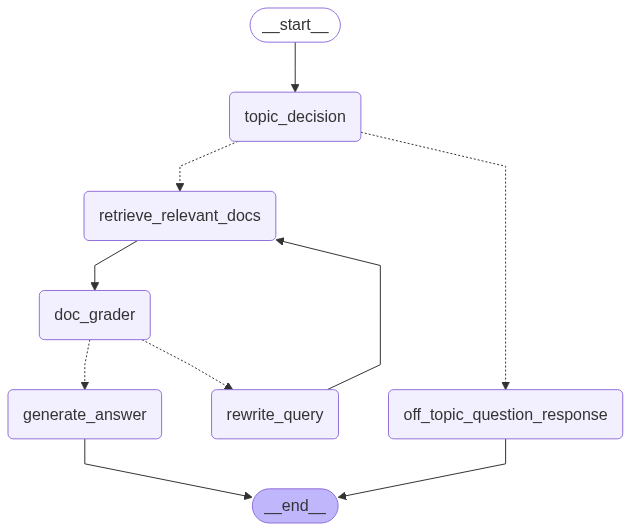

In [ ]:
display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
result = workflow.invoke({"question": "who is the owner of the Bella vista?"})
result["llm_output"]

'The owner of Bella Vista is Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry.'

In [ ]:
result = workflow.invoke({"question": "How is the weather?"})
result["llm_output"]

"Sorry! I can't respond to that!"